# Two Sector Hank (Formal and Informal No Labor Mobility)
## Test: Both Sectors are identical (2 formal sectors)
There is a continuum of two ex-ante identical households. Type one works in sector formal ($f$) and the other in sector ($i$). 
Only the formal type can be taxed by the government.

In [22]:
from ConsIndShockModel_HANK import IndShockConsumerType 
import sequence_jacobian as sj  # SSJ will allow us to define blocks, models, compute IRFs, etc
from sequence_jacobian.classes import JacobianDict, SteadyStateDict
from sequence_jacobian import het, simple, create_model              # functions
import matplotlib.pyplot as plt
import numpy as np
import time

from scipy import optimize

In [23]:
def show_irfs(irfs_list, variables, labels=[" "], ylabel=r"Percentage points (dev. from ss)", T_plot=50, figsize=(18, 6)):
    if len(irfs_list) != len(labels):
        labels = [" "] * len(irfs_list)
    n_var = len(variables)
    fig, ax = plt.subplots(1, n_var, figsize=figsize, sharex=True)
    for i in range(n_var):
        # plot all irfs
        for j, irf in enumerate(irfs_list):
            ax[i].plot(100 * irf[variables[i]][:50], label=labels[j])
        ax[i].set_title(variables[i])
        ax[i].set_xlabel(r"$t$")
        if i==0:
            ax[i].set_ylabel(ylabel)
        ax[i].legend()
    plt.show()

In [24]:
## psize is the size of the formal sector.
psize = 0.5
pformal_share = psize/(1-psize)
wage_share = 1.0

In [25]:
UnempPrb_f = 0.05
IncUnemp_f = 0.0

In [26]:
# Defining steady state values of the economy
def fiscal_ss(B, r, G): 
    T = (1 + r) * B + G - B + (UnempPrb_f * IncUnemp_f) * psize    
    return T

r_ss = 1.03 - 1
G_ss = .2
B_ss = 0.25 # this is lower than the tutorial by Straub et al. because need Higher MPC
Y_ss = 1.0

T_ss = fiscal_ss(B_ss,r_ss,G_ss)
print('T_ss: ' +str(T_ss))

# Z_ss = Y_ss - T_ss 
Zf_ss = (Y_ss * psize * wage_share) - (T_ss * psize)
Zi_ss = (Y_ss*(1-psize) /wage_share) - (T_ss * (1-psize)) # Both sectors can be taxed

C_ss = Y_ss - G_ss

print('Zf_ss: ' +str(Zf_ss))
print('Zi_ss: ' +str(Zi_ss))
print('C_ss: ' +str(Y_ss - G_ss))

T = 300 # Dimention of TxT Jacobian matrix

T_ss: 0.20750000000000002
Zf_ss: 0.39625
Zi_ss: 0.39625
C_ss: 0.8


In [27]:
HANK_Dict_Formal = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Zf_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = (1- taxrate)*labor*wage
    return z

HANK_Dict_Formal['TranShkMean_Func'] = [function]

In [28]:
HANK_Dict_Informal = {
    # Parameters shared with the perfect foresight model
    "Rfree": 1.0 + r_ss,                    # Interest factor on assets
    "LivPrb" : [.99375],                   # Survival probability

    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [.06],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 5,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 5,    
    
    # HANK params
    "taxrate" : [0.0], # set to 0.0 because we are going to assume that labor here is actually after tax income
    "labor": [Zi_ss],
    "wage": [1.0],    
    
    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                      # Probability of unemployment while working
    "IncUnemp" :  0.0,                     # Unemployment benefits replacement rate
  
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMax" : 500,                      # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 100,                     # Number of points in the base grid of "assets above minimum"
    "BoroCnstArt": 0.0,
    
    # Transition Matrix simulation parameters
    "mCount": 200,
    "mMax": 500,
    "mMin": 1e-5,
    "mFac": 3,

    # Hank model bool
    "HANK":True,     
}

# to add taxes, labor, and wage. This ensures that we can shock each variable.
def function(taxrate, labor, wage):
    
    z = labor*wage
    return z

HANK_Dict_Informal['TranShkMean_Func'] = [function]

In [29]:
### Target Steady State Asset
def ss_func(beta):
    HANK_Dict_Formal['DiscFac'] = beta
    AgentFormal_func = IndShockConsumerType(**HANK_Dict_Formal, verbose = False)
    Af_ss = AgentFormal_func.compute_steady_state()[0]
    HANK_Dict_Informal['DiscFac'] = beta
    AgentInformal_func = IndShockConsumerType(**HANK_Dict_Informal, verbose = False)
    Ai_ss = AgentInformal_func.compute_steady_state()[0]   
    A_ss = psize * Af_ss + (1 - psize)* Ai_ss 
    return A_ss
    

def ss_dif(beta):    
    # difference =   ss_func(beta) - Asset_target 
    # print(difference)
    return ss_func(beta) - Asset_target 

Asset_target = B_ss
DiscFac = optimize.brentq(ss_dif,.75,.99)

In [30]:
DiscFac

0.8424405400614482

In [31]:
# Create a new agent
HANK_Dict_Formal['DiscFac'] = DiscFac
AgentFormal_GE = IndShockConsumerType(**HANK_Dict_Formal, verbose = False)
HANK_Dict_Informal['DiscFac'] = DiscFac
AgentInformal_GE = IndShockConsumerType(**HANK_Dict_Informal, verbose = False)

In [32]:
print(DiscFac)

0.8424405400614482


In [33]:
Af_ss, Cf_ss = AgentFormal_GE.compute_steady_state()
Ai_ss, Ci_ss = AgentInformal_GE.compute_steady_state()

# MPC = Agent_GE.calc_jacobian('labor',T)[0][0][0]
# print('Our general equilibrium agent has a discount rate of: ' + "%.2f" % Agent_GE.DiscFac +'. Where the steady state MPC is ' + "%.2f" % MPC + ' and Bond Holdings are ' + "%.2f" % A_ss)

In [34]:
A_ss = psize * Af_ss + (1 - psize) * Ai_ss 
C_ss = psize * Cf_ss + (1 - psize) * Ci_ss 

print(A_ss, C_ss)

0.24999999999976805 0.3996641275905586


In [35]:
print(B_ss)

0.25


In [36]:
start = time.time()

CJACR_f, AJACR_f = AgentFormal_GE.calc_jacobian('Rfree',T)
CJACZ_f, AJACZ_f = AgentFormal_GE.calc_jacobian('labor', T)

CJACR_i, AJACR_i = AgentInformal_GE.calc_jacobian('Rfree',T)
CJACZ_i, AJACZ_i = AgentInformal_GE.calc_jacobian('labor', T)

print('Seconds to calculate Jacobian', time.time() - start)

Seconds to calculate Jacobian 19.778841495513916


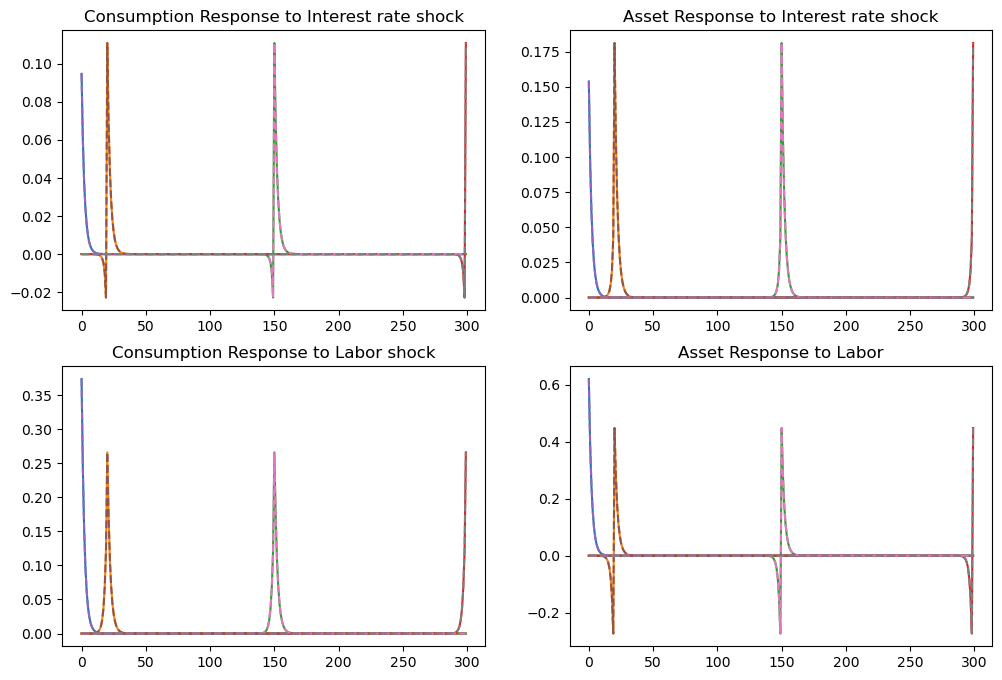

In [37]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Consumption Response to Interest rate shock
axs[0, 0].plot(CJACR_f.T[0])
axs[0, 0].plot(CJACR_f.T[20])
axs[0, 0].plot(CJACR_f.T[150])
axs[0, 0].plot(CJACR_f.T[-1])
axs[0, 0].plot(CJACR_i.T[0], '--', label = 'informal')
axs[0, 0].plot(CJACR_i.T[20], '--', label = 'informal')
axs[0, 0].plot(CJACR_i.T[150], '--', label = 'informal')
axs[0, 0].plot(CJACR_i.T[-1], '--', label = 'informal')
axs[0, 0].set_title("Consumption Response to Interest rate shock")

# Asset Response to Interest rate shock
axs[0, 1].plot(AJACR_f.T[0])
axs[0, 1].plot(AJACR_f.T[20])
axs[0, 1].plot(AJACR_f.T[150])
axs[0, 1].plot(AJACR_f.T[-1])
axs[0, 1].plot(AJACR_i.T[0], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[20], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[150], '--', label = 'informal')
axs[0, 1].plot(AJACR_i.T[-1], '--', label = 'informal')
axs[0, 1].set_title("Asset Response to Interest rate shock")

# Consumption Response to Labor shock
axs[1, 0].plot(CJACZ_f.T[0])
axs[1, 0].plot(CJACZ_f.T[20])
axs[1, 0].plot(CJACZ_f.T[150])
axs[1, 0].plot(CJACZ_f.T[-1])
axs[1, 0].plot(CJACZ_i.T[0], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[20], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[150], '--', label = 'informal')
axs[1, 0].plot(CJACZ_i.T[-1], '--', label = 'informal')
axs[1, 0].set_title("Consumption Response to Labor shock")

# Asset Response to Labor
axs[1, 1].plot(AJACZ_f.T[0])
axs[1, 1].plot(AJACZ_f.T[20])
axs[1, 1].plot(AJACZ_f.T[150])
axs[1, 1].plot(AJACZ_f.T[-1])
axs[1, 1].plot(AJACZ_i.T[0], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[20], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[150], '--', label = 'informal')
axs[1, 1].plot(AJACZ_i.T[-1], '--', label = 'informal')
axs[1, 1].set_title("Asset Response to Labor")

plt.show()

In [38]:
HARK_SteadyState_Dict = SteadyStateDict({"C": C_ss, "Cf": Cf_ss, "Ci": Ci_ss, "r": r_ss, "Y": Y_ss, "B": B_ss, "G": G_ss, "A": A_ss, "Af": Af_ss, "Ai": Ai_ss})
HARK_Jacobian_Dict = JacobianDict( { 'Cf' : {'Zf' : CJACZ_f, 'r': CJACR_f} ,'Af' : {'Zf' : AJACZ_f, 'r': AJACR_f}, 'Ci' : {'Zi' : CJACZ_i, 'r': CJACR_i} ,'Ai' : {'Zi' : AJACZ_i, 'r': AJACR_i} } ) 

In [39]:
@sj.simple
def fiscal(B, r, G, Y): 
    T = (1 + r) * B(-1) + G - B + UnempPrb_f * IncUnemp_f * psize # total tax burden
    Zf = Y * psize * wage_share - (T * psize) #(T * psize)
    Zi = Y *(1 - psize) / wage_share - ( T* (1 - psize))
    deficit = G - T
    
    return T, Zf, Zi, deficit


# @sj.simple
# def fiscal(B, r, G, Y): 
#     T = (1 + r) * B(-1) + G - B  # total tax burden
#     Zf = (Y*pformal * wage_share) - (T *pformal)
#     Zi = (Y*(1-pformal) / wage_share)  - (T * (1-pformal))

#     deficit = G - T
    
#     return T, Zf, Zi, deficit

# @sj.simple
# def Firm(Z, T):


#     return Zf, Zi


@sj.simple
def aggregation(Cf, Ci, Af, Ai):
    C = Cf * psize + (1 - psize) * Ci
    A = Af * psize + (1 - psize) * Ai

    return C, A


@sj.simple
def mkt_clearing(A, B, Y, C, G):
    asset_mkt = A - B
    goods_mkt = C + G - Y
    
    return asset_mkt, goods_mkt

In [40]:
# Create the model and specify attributes
HARK_HANK = create_model([HARK_Jacobian_Dict, fiscal, aggregation, mkt_clearing], name="HARK_HANK")
unknowns = ['Y']
targets = ['asset_mkt']
exogenous = ['G']

In [41]:
# First, we analyze a government spending shock.
G_std = .01
G_persistence = .8
dG =  G_std * G_persistence**np.arange(T)
shocks_G = {"G": dG}

In [42]:
# Create the IRFs
irfs_G = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_G)

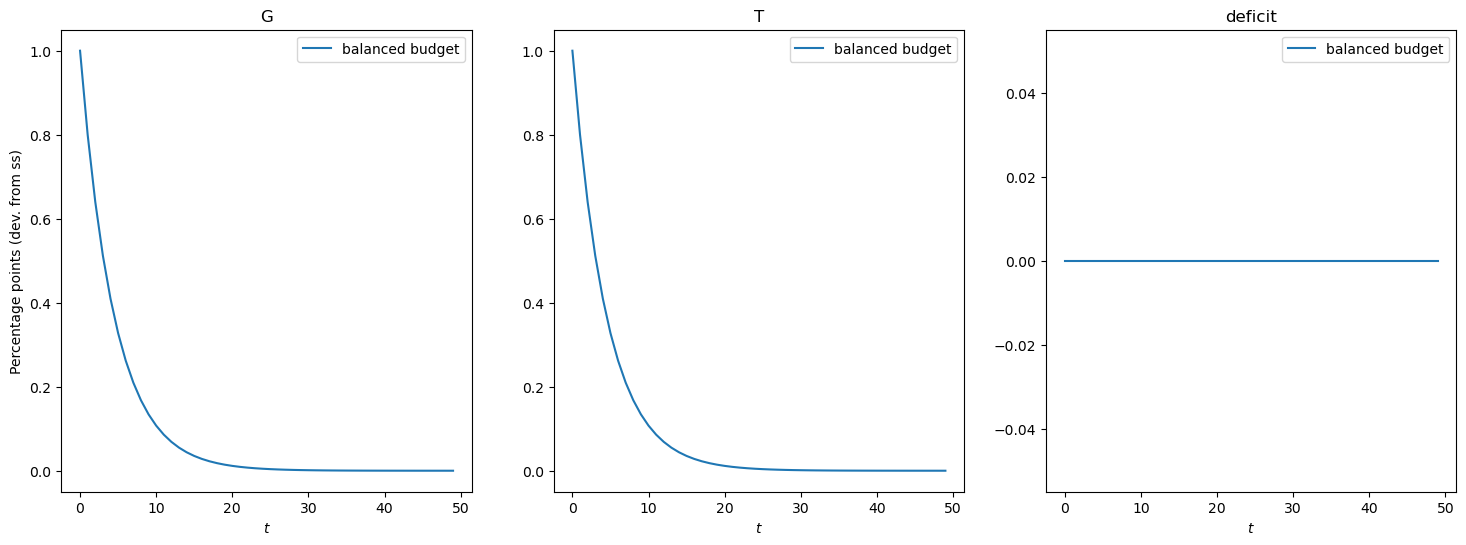

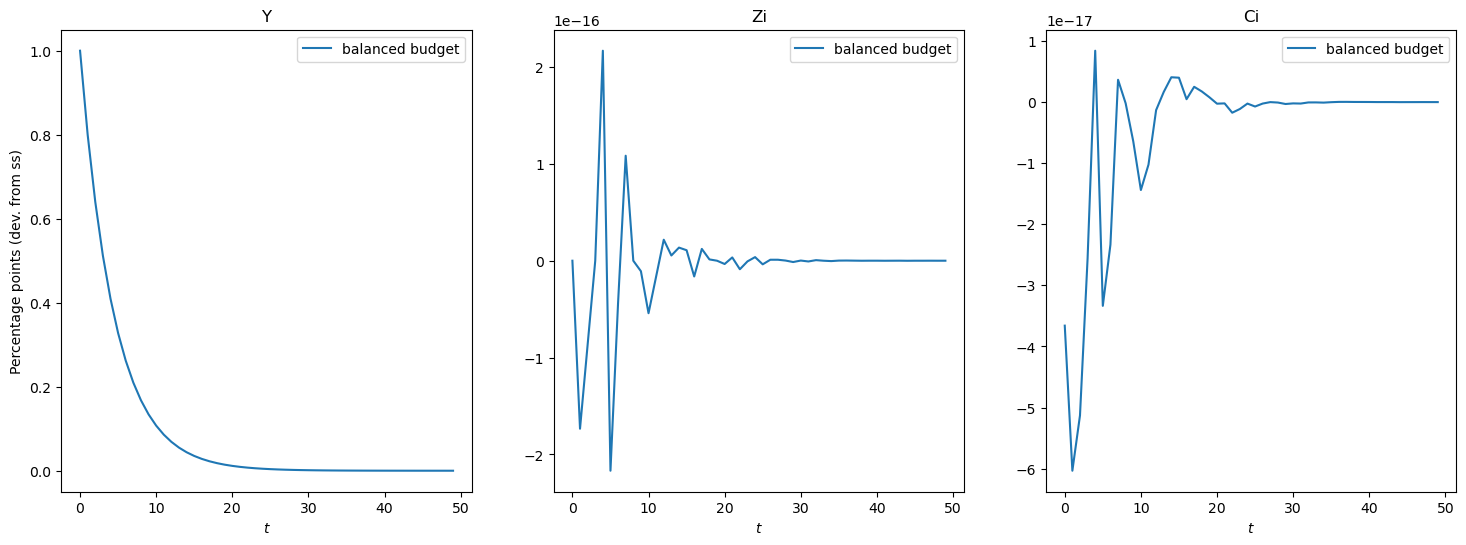

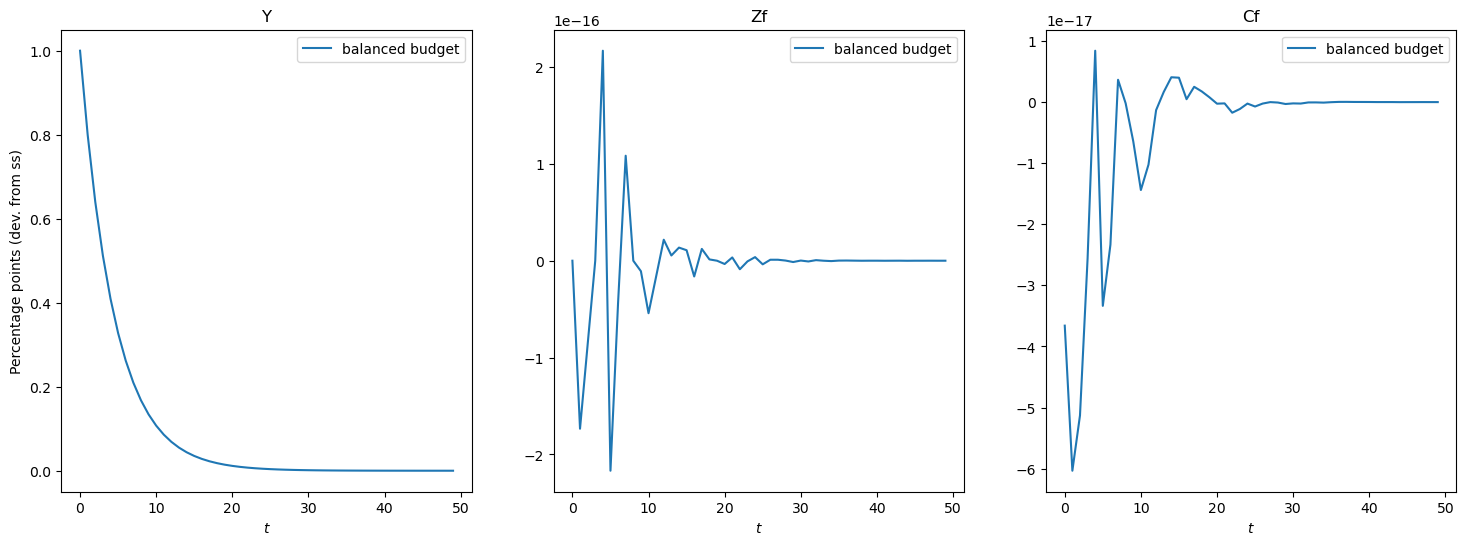

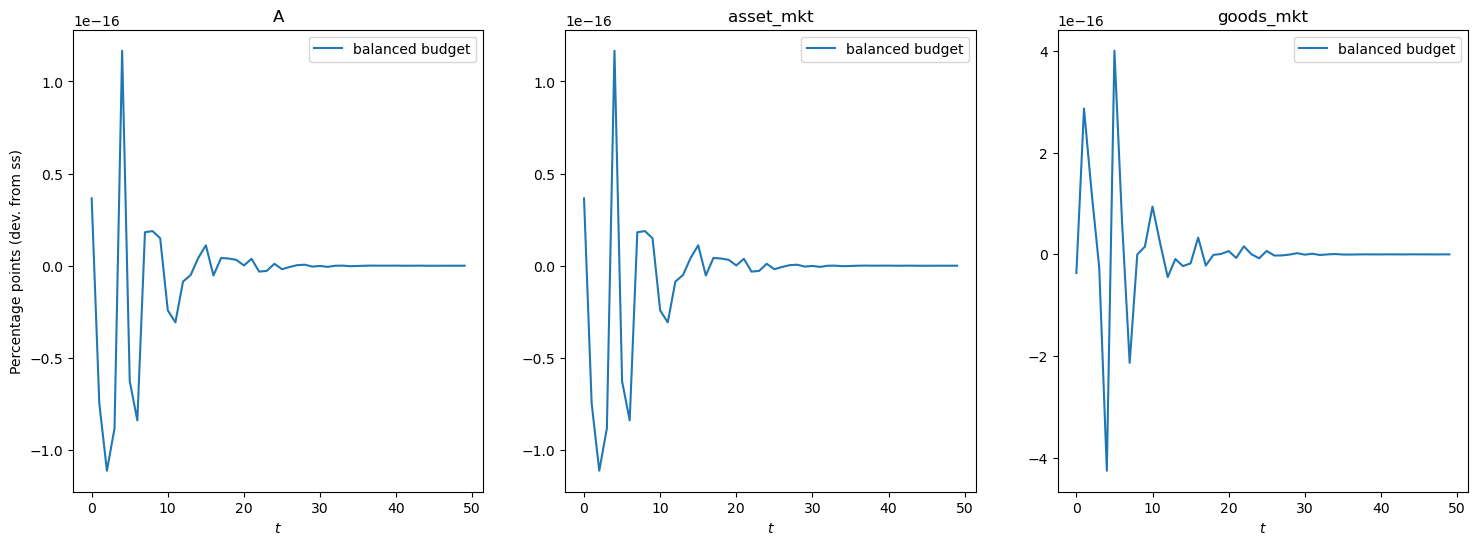

In [43]:
# Plot them
show_irfs([irfs_G], ['G', 'T', 'deficit'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Zi', 'Ci'], labels=["balanced budget"])
show_irfs([irfs_G], ['Y', 'Zf', 'Cf'], labels=["balanced budget"])

show_irfs([irfs_G], ['A','asset_mkt', 'goods_mkt'], labels=["balanced budget"])

In [44]:
# Deficit Spending
rho_B = 0.8
dB = np.cumsum(dG) * rho_B ** np.arange(T)
shocks_B = {'G': dG, 'B': dB}

irfs_B = HARK_HANK.solve_impulse_linear(HARK_SteadyState_Dict, unknowns, targets, shocks_B)

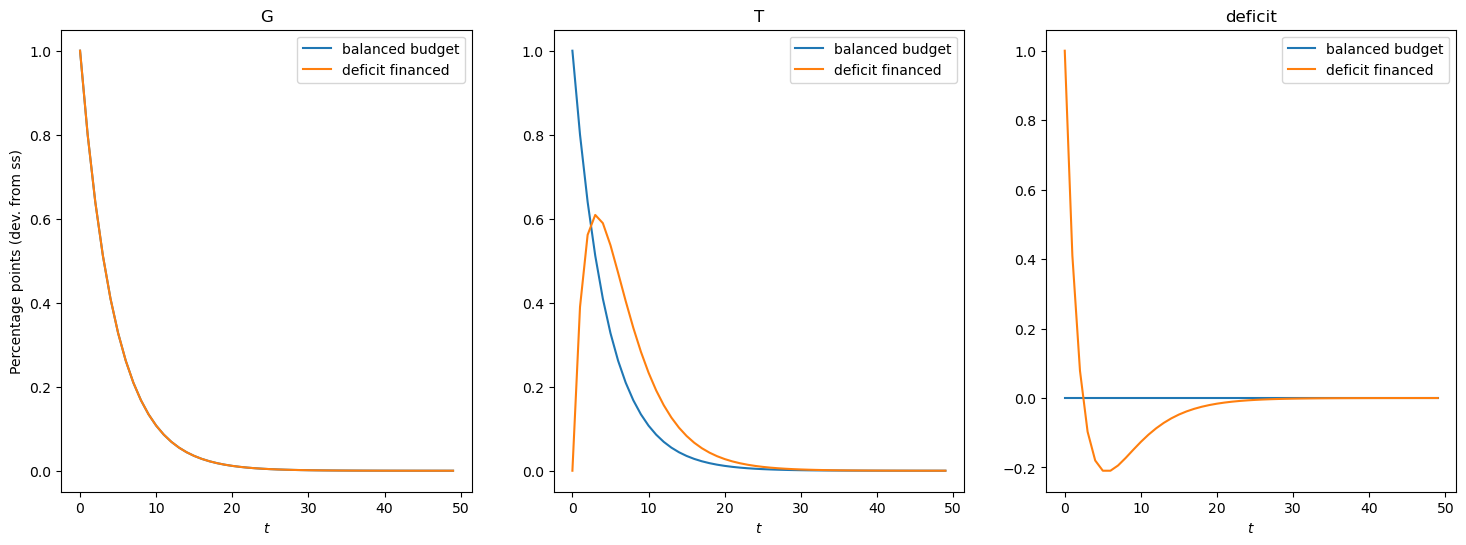

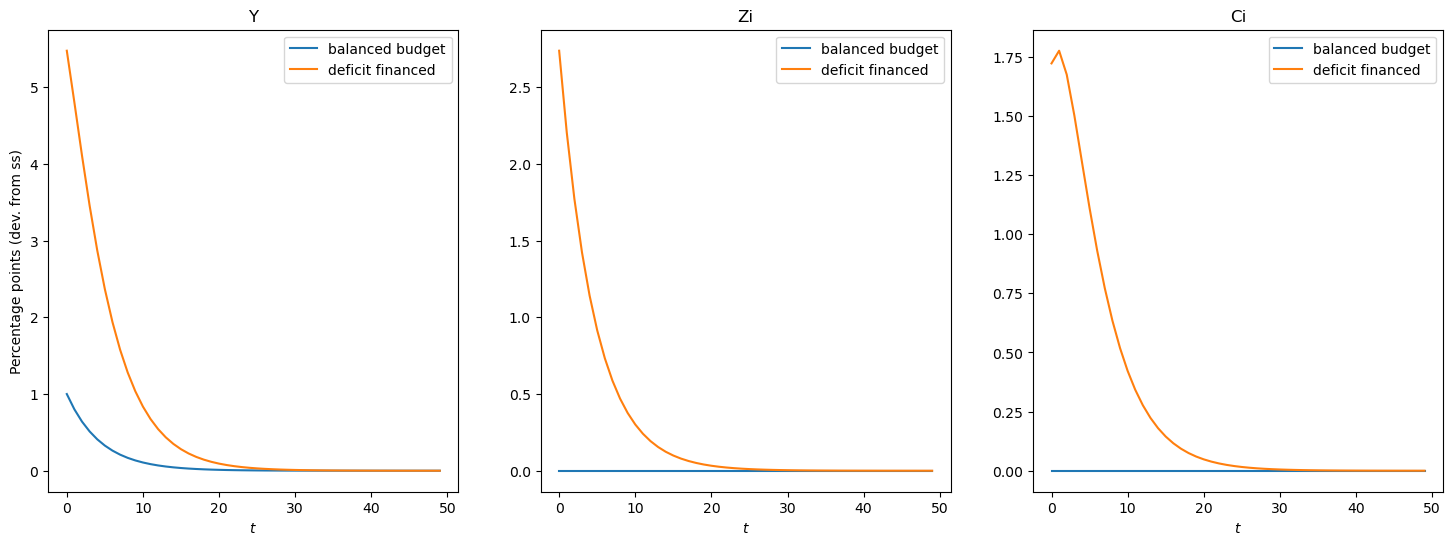

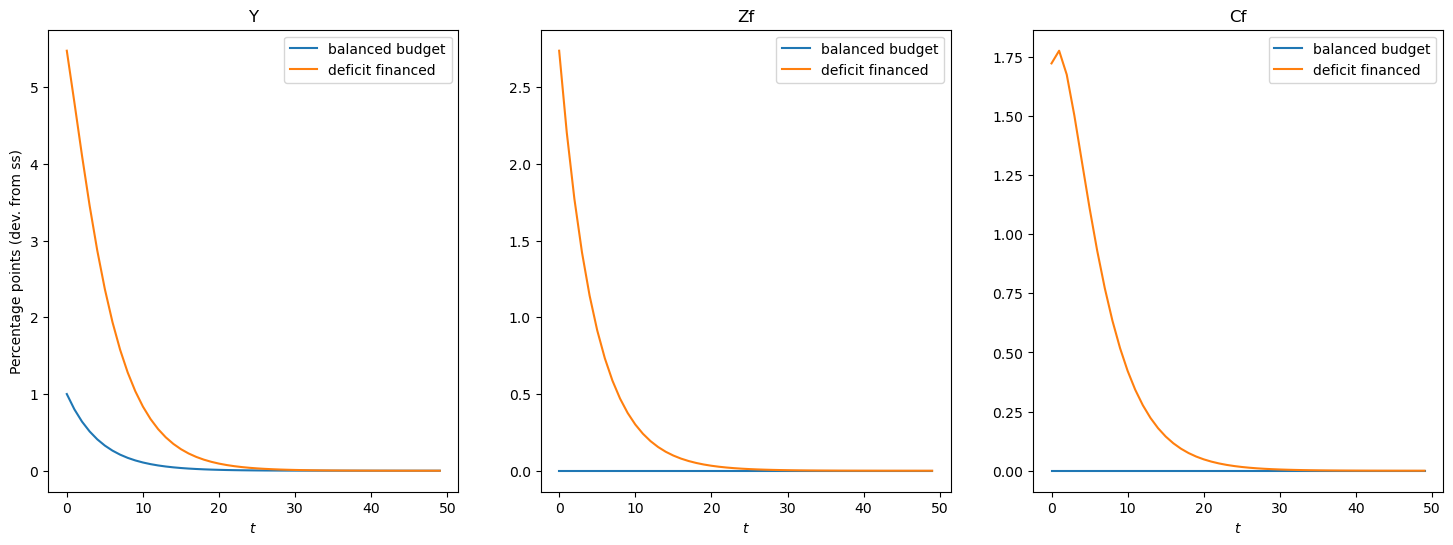

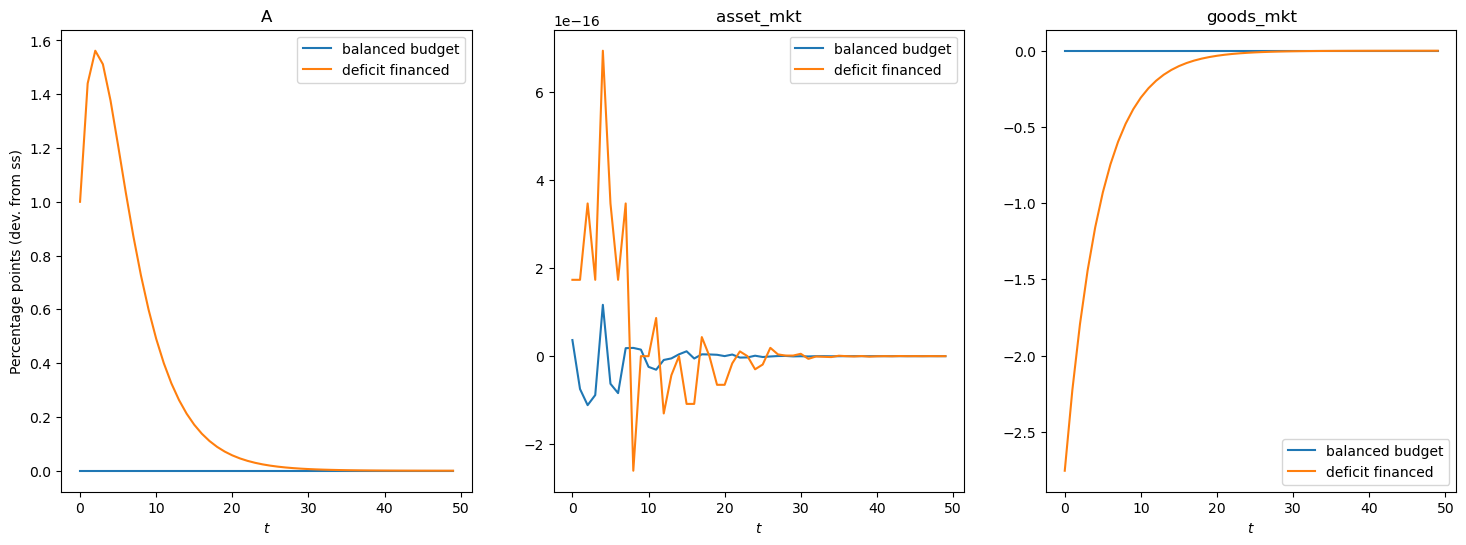

In [45]:
show_irfs([irfs_G, irfs_B], ['G', 'T', 'deficit'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zi', 'Ci'], labels=["balanced budget", "deficit financed"])
show_irfs([irfs_G, irfs_B], ['Y', 'Zf', 'Cf'], labels=["balanced budget", "deficit financed"])

show_irfs([irfs_G, irfs_B], ['A', 'asset_mkt', 'goods_mkt'], labels=["balanced budget", "deficit financed"])